In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from src.shap_show import shap_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from src.preprocess_data import preprocess_data, clean_text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from src.FastTextVectorizer import FastTextVectorizer
from src.utils import *
from src.find_optimal_threshold import find_optimal_threshold



d:\py\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data\\train.csv')
TARGET = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
RANDOM_STATE = 42
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


<BarContainer object of 6 artists>

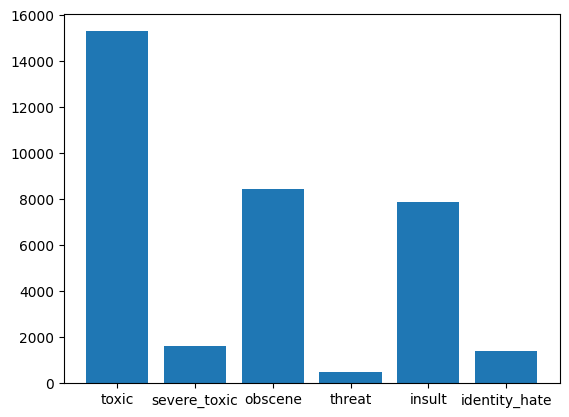

In [3]:
plt.bar(TARGET, df[[x for x in TARGET]].sum())

In [4]:
non_toxic_count = df[df[TARGET].sum(axis=1) == 0].shape[0]
toxic_count = df[df[TARGET].sum(axis=1) > 0].shape[0]
total_count = df.shape[0]
toxic_percent = toxic_count / total_count * 100

print(f'About the dataset: ',
    f'total samples: {total_count} ',
    f'Non-toxic samples: {non_toxic_count} ',
    f'Toxic samples: {toxic_count} '
    f'({toxic_percent:.2f}%) toxic samples',
    sep='\n')

About the dataset: 
total samples: 159571 
Non-toxic samples: 143346 
Toxic samples: 16225 (10.17%) toxic samples


Baseline:

TF-IDF + Logistic Regression / Linear SVM

In [5]:
train_df, val_df  = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

In [6]:
model_tf_idf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), preprocessor=clean_text)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
])
model_tf_idf.fit(train_df['comment_text'], train_df[TARGET])
prob_tf_idf = model_tf_idf.predict_proba(val_df['comment_text'])

In [7]:
print("--------------------------------")
print("Metrics with default threshold:")
metrics_model(val_df[TARGET], prob_tf_idf)
best_thresholds, best_scores = find_optimal_threshold(val_df[TARGET].values, prob_tf_idf)
print("Metrics with optimal thresholds:")
metrics_model(val_df[TARGET], prob_tf_idf, thresholds=best_thresholds)
print(f'Validation ROC-AUC Score: {roc_auc_score(val_df[TARGET], prob_tf_idf)}')


--------------------------------
Metrics with default threshold:
--------------------------------
F1 Score (macro): 0.4884
F1 Score (micro): 0.6696
Accuracy: 0.9183
Precision: 0.3324
Recall: 0.3775
--------------------------------
              precision    recall  f1-score   support

           0       0.90      0.60      0.72      3056
           1       0.58      0.25      0.35       321
           2       0.91      0.61      0.73      1715
           3       0.79      0.15      0.25        74
           4       0.84      0.50      0.63      1614
           5       0.72      0.15      0.25       294

   micro avg       0.88      0.54      0.67      7074
   macro avg       0.79      0.38      0.49      7074
weighted avg       0.87      0.54      0.66      7074
 samples avg       0.05      0.05      0.05      7074

Metrics with optimal thresholds:


d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarnin

--------------------------------
F1 Score (macro): 0.5918
F1 Score (micro): 0.7144
Accuracy: 0.9094
Precision: 0.3888
Recall: 0.6129
--------------------------------
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      3056
           1       0.49      0.49      0.49       321
           2       0.83      0.75      0.79      1715
           3       0.37      0.46      0.41        74
           4       0.68      0.74      0.71      1614
           5       0.33      0.52      0.41       294

   micro avg       0.72      0.71      0.71      7074
   macro avg       0.58      0.61      0.59      7074
weighted avg       0.73      0.71      0.72      7074
 samples avg       0.06      0.06      0.06      7074

Validation ROC-AUC Score: 0.9710443590112909


97.1 % ROC AUC

In [8]:
print(model_tf_idf.predict(["FUCK"]), model_tf_idf.predict(["F1ACK"]), model_tf_idf.predict(["F U C K"]))

[[1 1 1 0 1 0]] [[0 0 0 0 0 0]] [[0 0 0 0 0 0]]


TOXIC WORDS:
['fuck' 'fucking' 'stupid' 'shit' 'idiot' 'ass' 'bullshit' 'asshole'
 'crap' 'suck' 'bitch' 'dick' 'sucks' 'penis' 'you' 'faggot' 'moron'
 'hell' 'pathetic' 'cunt']

NON-TOXIC WORDS:
['thank' 'thanks' 'thank you' 'talk' 'best' 'please' 'utc' 'welcome'
 'if you' 'help' 'may' 'see' 'wp' 'at' 'interested' 'could' 'sorry'
 'cheers' 'appreciate' 'article']


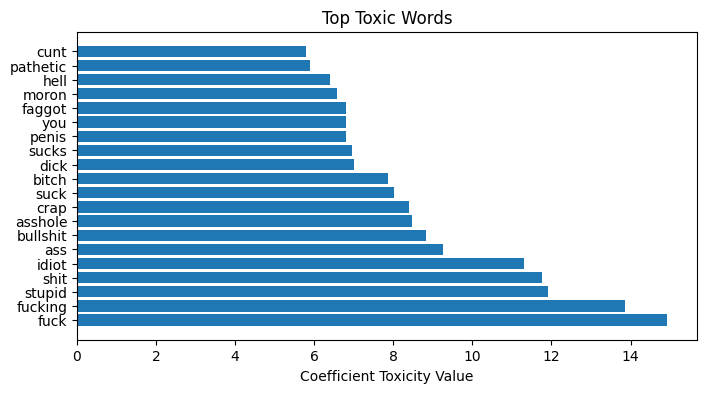

In [9]:
# shap_model(model_tf_idf.named_steps['clf'], model_tf_idf.named_steps['tfidf'], train_df)
get_top_tox(model_tf_idf.named_steps['tfidf'], model_tf_idf.named_steps['clf'])

FastText:
- Word embeddings + Linear classifier


In [10]:
FastText_pipeline = Pipeline([
    ('fasttext', FastTextVectorizer(vector_size=300, window=3, epochs=20, min_n=3, max_n=6)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear')))
])
FastText_pipeline.fit(train_df['comment_text'], train_df[TARGET])
FastText_val_probs = FastText_pipeline.predict_proba(val_df['comment_text'])

In [11]:
print("--------------------------------")
best_thresholds, best_scores = find_optimal_threshold(val_df[TARGET].values, FastText_val_probs)
print("Metrics with optimal thresholds:")
metrics_model(val_df[TARGET], FastText_val_probs, thresholds=best_thresholds)
print(f'Validation ROC-AUC Score: {roc_auc_score(val_df[TARGET], FastText_val_probs)}')




--------------------------------
Metrics with optimal thresholds:
--------------------------------
F1 Score (macro): 0.2561
F1 Score (micro): 0.3425
Accuracy: 0.8285
Precision: 0.1062
Recall: 0.3038
--------------------------------
              precision    recall  f1-score   support

           0       0.34      0.43      0.38      3056
           1       0.23      0.37      0.28       321
           2       0.34      0.38      0.36      1715
           3       0.05      0.05      0.05        74
           4       0.33      0.38      0.35      1614
           5       0.08      0.21      0.12       294

   micro avg       0.31      0.39      0.34      7074
   macro avg       0.23      0.30      0.26      7074
weighted avg       0.32      0.39      0.35      7074
 samples avg       0.03      0.03      0.03      7074

Validation ROC-AUC Score: 0.8201237996079894


d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\py\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


- Модель на FastText не интерпретирует токсичность через наличие конкретных оскорбительных слов, а опирается на распределённые семантические представления и структурные шаблоны высказываний. Вклад слов отражает их влияние на линейную часть классификатора, а не их «токсичность» как таковую.
- В отличие от TF-IDF, FastText-модель менее чувствительна к словарю ругательств и лучше обобщает на новые формулировки, но её интерпретируемость требует анализа вкладов embedding’ов, а не отдельных токенов.

In [12]:
word_contributions("You are a real genius", FastText_pipeline.named_steps['fasttext'], model=FastText_pipeline.named_steps['clf'])
explain_text("You are a real genius", model_tf_idf.named_steps['tfidf'], model_tf_idf.named_steps['clf'])
word_contributions("You are a fucking idiot", FastText_pipeline.named_steps['fasttext'], model=FastText_pipeline.named_steps['clf'])
explain_text("You are a fucking idiot", model_tf_idf.named_steps['tfidf'], model_tf_idf.named_steps['clf'])



{'a': 0.07157033319655491, 'you': 0.04516311685875584, 'are': 0.0063479416121257695, 'genius': 0.0035090865717363937, 'real': -0.002807351773483264}
           word  contribution
4           you      1.759784
3          real      0.951855
2           are      0.696254
1       you are      0.545579
0  yourself but     -0.000000
{'a': 0.07157033319655491, 'you': 0.04516311685875584, 'fucking': 0.011727398235223596, 'are': 0.0063479416121257695, 'idiot': -0.003727078841143528}
      word  contribution
4  fucking      7.987715
3    idiot      7.464834
2      you      1.235899
1      are      0.488981
0  you are      0.383161


Метрики BERT модели:

Метрики с оптимальными порогами:

- F1 Score (macro): 0.6039
- F1 Score (micro): 0.7130
- Accuracy: 0.9082
- Precision: 0.3973
- Recall: 0.6274

Validation ROC-AUC Score (BERT): 0.9777

In [14]:
import os
import sys
import joblib

os.makedirs('model/', exist_ok=True)
thresholds_map = dict(zip(TARGET, best_thresholds))

print("Saving TF-IDF model...")
joblib.dump(model_tf_idf.named_steps['tfidf'], 'model/tfidf_vectorizer.pkl')
joblib.dump(model_tf_idf.named_steps['clf'], 'model/tfidf_classifier.pkl')
joblib.dump(thresholds_map, 'model/thresholds.pkl') 

print("Saved TF-IDF model and classifier.")

Saving TF-IDF model...
Saved TF-IDF model and classifier.
